# Solving DSGEs in Python

## 1. The Starting Point
We're going to start with the basic RBC Model.

### 1.1 Equations and Approach
The model is described by 6 equations in 6 unknowns $x_t = \{c_t,k_t,l_t,w_t,r_t,z_t\}$ and one exogenous shock $u_t = \epsilon_t$. Here are the equations:
$$
\begin{align*}
    \mathbb{E}_t[h_1(x_{t+1},x_t,x_{t-1},u_t)] & = \beta \mathbb{E}_t\left[(1+r_{t+1})c_{t+1}^{-\sigma}\right] - c_t^{-\sigma}=0\\
    \mathbb{E}_t[h_2(x_{t+1},x_t,x_{t-1},u_t)] & = \psi c_t^{\sigma}l_t^\phi - w_t=0\\
    \mathbb{E}_t[h_3(x_{t+1},x_t,x_{t-1},u_t)] & = \alpha e^{z_t} k_{t-1}^{\alpha -1}l_t^{1-\alpha} - (r_t + \delta)=0\\
    \mathbb{E}_t[h_4(x_{t+1},x_t,x_{t-1},u_t)] & = (1-\alpha) e^{z_t} k_{t-1}^{\alpha}l_t^{-\alpha} - w_t=0\\
    \mathbb{E}_t[h_5(x_{t+1},x_t,x_{t-1},u_t)] & = e^{z_t}k_{t-1}^\alpha l_t^{1-\alpha} + (1-\delta)k_{t-1} - k_t - c_t=0\\
    \mathbb{E}_t[h_6(x_{t+1},x_t,x_{t-1},u_t)] & = (1-\rho)\mu + \rho z_{t-1} +\sigma_\epsilon\epsilon_t - z_t =0.
\end{align*}
$$

We can stack all the $\mathbb{E}_{t}[h_i(x_{t+1},x_t,x_{t-1},u_t)]$ terms into a $6\times1$ vector, which will form the non-linear system $\mathbb{E}_{t}[H(x_{t+1},x_t,x_{t-1},u_t)]$. We can linearize this system around the no-uncertainty steady state $x_{t+1} = x_t = x_{t-1} = x_*$. This involves computing the Jacobians of $H$ with respect of $x_{t+1}$, $x_t$, $x_{t-1}$, and $u_t$, which are
$$
\begin{align*}
    A& =\frac{\partial H}{\partial x_{t+1}}(x_*,x_*,x_*,0)\\
    B&=\frac{\partial H}{\partial x_{t}}(x_*,x_*,x_*,0)\\
    C&=\frac{\partial H}{\partial x_{t-1}}(x_*,x_*,x_*,0)\\
    F&=\frac{\partial H}{\partial u_{t}}(x_*,x_*,x_*,0).
\end{align*}
$$

With these Jacobians, we have the linearized system
$$
\begin{align*}
    \mathbf{0}_{6\times 1}&= A\mathbb{E}_t[dx_{t+1}] + Bdx_{t}+Cdx_{t-1} + Fdu_{t}.
\end{align*}
$$
That means all we need to do is compute the Jacobians to get this in a form we can solve using standard methods for linear rational expectations models! Fortunately, this is very easy. We'll see that now.

### 1.2 Linearize It!

First, we've got to load in some packages that will do our heavy lifting.

In [1]:
# load in some packages for the computational stuff
# 'jax' is the engine behind all of the differentiation we'll do
import numpy as np
from jax import jit, jacfwd
from jax import numpy as jnp
from scipy.linalg import ordqz

In [3]:
# just parameters for plotting everything
# feel free to ignore
%config InlineBackend.figure_format = 'svg'
import matplotlib
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Helvetica' 
import matplotlib.pyplot as plt
dark_theme = False
if dark_theme:
    plt.rcParams.update({
        "lines.color": "white",
        "patch.edgecolor": "white",
        "text.color": "white",
        "axes.facecolor": "black",
        "axes.edgecolor": "white",
        "axes.labelcolor": "white",
        "xtick.color": "white",
        "ytick.color": "white",
        "grid.color": "white",
        "figure.facecolor": "black",
        "figure.edgecolor": "black",
        "savefig.facecolor": "black",
        "savefig.edgecolor": "black"})

Before we get into anything, we're just going to write a function to compute the steady state.

In [4]:
def steady_state(params):
    alpha   = params[0]
    beta    = params[1]
    delta   = params[2]
    mu      = params[3]
    phi     = params[4]
    psi     = params[5]
    rho     = params[6]
    sigma   = params[7]
    sig_eps = params[8]
    
    x_star    = jnp.zeros(6)
    x_star    = x_star.at[5].set(mu)
    x_star    = x_star.at[4].set(1.0 / beta - 1.0)
    kl_ratio  = (alpha * np.exp(x_star[5]) / (x_star[4] + delta)) ** (1.0 / (1.0 - alpha))
    cl_ratio  = np.exp(x_star[5]) * kl_ratio ** alpha - delta ** kl_ratio
    x_star    = x_star.at[3].set((1.0 - alpha) * jnp.exp(x_star[5]) * kl_ratio ** alpha)
    x_star    = x_star.at[2].set(cl_ratio ** (-sigma / (phi + sigma)) * (x_star[3] / psi) ** (1.0 / (phi + sigma)))
    x_star    = x_star.at[1].set(kl_ratio * x_star[2])
    x_star    = x_star.at[0].set(cl_ratio * x_star[2])
    
    return x_star

In [5]:
alpha0   = 0.3
beta0    = 0.98
delta0   = 0.05
mu0      = 0.0
phi0     = 1.0
psi0     = 1.0
rho0     = 0.98
sigma0   = 2.0
sig_eps0 = 0.05

params0 = np.array([alpha0, beta0, delta0, mu0, phi0, psi0, rho0, sigma0, sig_eps0], dtype=float)

In [6]:
x_ss = steady_state(params0)

In [7]:
x_ss

Array([1.3434535 , 5.72428   , 0.72183454, 1.3028158 , 0.02040816,
       0.        ], dtype=float32)

Now, we're defining our residual equations according to how they were above.

In [8]:
@jit
def resid(xp, x0, xm, u0, params):
    alpha   = params[0]
    beta    = params[1]
    delta   = params[2]
    mu      = params[3]
    phi     = params[4]
    psi     = params[5]
    rho     = params[6]
    sigma   = params[7]
    sig_eps = params[8]
    
    h_vec = jnp.zeros(6,float)
    
    h_vec = h_vec.at[0].set(beta * (1.0 + xp[4]) * xp[0] ** (-sigma) - x0[0] ** (-sigma))
    h_vec = h_vec.at[1].set(psi * x0[0] ** (sigma) * x0[2] ** phi - x0[3])
    h_vec = h_vec.at[2].set(alpha * jnp.exp(x0[5]) * xm[1] ** (alpha - 1.0) * x0[2] ** (1.0 - alpha) - x0[4] - delta)
    h_vec = h_vec.at[3].set((1.0 - alpha) * jnp.exp(x0[5]) * xm[1] ** (alpha) * x0[2] ** (- alpha) - x0[3])
    h_vec = h_vec.at[4].set(jnp.exp(x0[5]) * xm[1] ** (alpha) * x0[2] ** (1.0 - alpha) + (1.0 - delta) * xm[1] - x0[1] - x0[0])
    h_vec = h_vec.at[5].set((1.0 - rho) * mu + rho * xm[5] + sig_eps * u0[0] - x0[5])
    
    return h_vec

In [9]:
A_mat = jacfwd(resid)(x_ss, x_ss, x_ss, np.zeros(1), params0)
B_mat = jacfwd(resid,argnums=1)(x_ss, x_ss, x_ss, np.zeros(1), params0)
C_mat = jacfwd(resid,argnums=2)(x_ss, x_ss, x_ss, np.zeros(1), params0)
F_mat = jacfwd(resid,argnums=3)(x_ss, x_ss, x_ss, np.zeros(1), params0)

Now, a light-weight function to implement Larry's method to solve LREs via undetermined coefficients.

In [10]:
def solve_lre(A, B, C, F):
    nn = np.shape(A)[0]
    
    phi0 = np.concatenate((np.concatenate((np.zeros((nn,nn)), np.eye(nn)),axis=1),
                           (np.concatenate((-C, -B),axis=1))))
    phi1 = np.concatenate((np.concatenate((np.eye(nn), np.zeros((nn,nn))),axis=1),
                           (np.concatenate((np.zeros((nn,nn)), A),axis=1))))
    
    _, _, al, be, _, Z_out = ordqz(phi0,phi1,sort='iuc')
    
    # asserts that the solution to the model exists and is unique
    assert np.sum((np.abs(al/be) < 1.0)) == nn
    
    P_mat = Z_out[nn:,0:nn] @ np.linalg.inv(Z_out[0:nn,0:nn])
    Q_mat = -np.linalg.inv(A @ P_mat + B) @ F
    
    return P_mat, Q_mat

In [11]:
P_out, Q_out = solve_lre(A_mat, B_mat, C_mat, F_mat)

/var/folders/3r/65tskzbn6hz4tzcvnqn6wp400000gn/T/ipykernel_1118/3215361071.py:12: RuntimeWarning: divide by zero encountered in divide
  assert np.sum((np.abs(al/be) < 1.0)) == nn
/var/folders/3r/65tskzbn6hz4tzcvnqn6wp400000gn/T/ipykernel_1118/3215361071.py:12: RuntimeWarning: invalid value encountered in divide
  assert np.sum((np.abs(al/be) < 1.0)) == nn


In [12]:
def get_irfs(P, Q, num_pers):
    irfs = np.zeros((*np.shape(Q), num_pers))
    irfs[:,:,0] = Q
    for i in range(num_pers - 1):
        irfs[:,:,i + 1] = P @ irfs[:,:,i]
    return irfs

In [13]:
irfs_out = get_irfs(P_out, Q_out, 100)

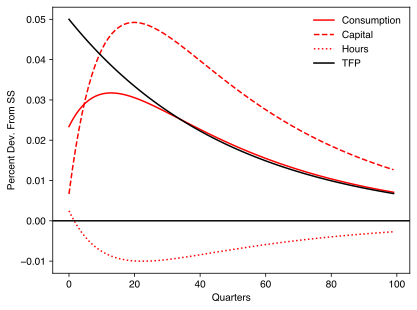

In [14]:
plt.plot(irfs_out[0,0,:] / x_ss[0], color='red',  label='Consumption')
plt.plot(irfs_out[1,0,:] / x_ss[1], color='red', linestyle='dashed', label='Capital')
plt.plot(irfs_out[2,0,:] / x_ss[2], color='red', linestyle='dotted', label='Hours')
plt.plot(irfs_out[5,0,:], color='black', label="TFP")
plt.axhline(y=0 , color='black')
plt.xlabel('Quarters')
plt.ylabel('Percent Dev. From SS')
plt.legend(frameon=False)

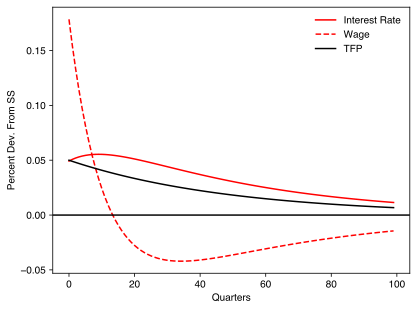

In [15]:
plt.plot(irfs_out[3,0,:] / x_ss[3], color='red',  label='Interest Rate')
plt.plot(irfs_out[4,0,:] / x_ss[4], color='red', linestyle='dashed', label='Wage')
plt.plot(irfs_out[5,0,:], color='black', label="TFP")
plt.axhline(y=0 , color='black')
plt.xlabel('Quarters')
plt.ylabel('Percent Dev. From SS')
plt.legend(frameon=False)

## 2. The Model With Habit

The model is described by 7 equations in 7 unknowns $x_t = \{c_t,k_t,l_t,w_t,r_t,z_t,h_t\}$ and one exogenous shock $u_t = \epsilon_t$. Here are the equations:
$$
\begin{align*}
    \mathbb{E}_t[h_1(x_{t+1},x_t,x_{t-1},u_t)] & = \beta \mathbb{E}_t\left[(1+r_{t+1})h_{t+1}\right]-h_t=0\\
    \mathbb{E}_t[h_2(x_{t+1},x_t,x_{t-1},u_t)] & = \psi l_t^\phi - w_t\left((h_{t-1}-\chi c_{t-1})^{-\sigma} - \chi \beta \mathbb{E}_t[(h_t-\chi c_{t})^{-\sigma}]\right)=0\\
    \mathbb{E}_t[h_3(x_{t+1},x_t,x_{t-1},u_t)] & = \alpha e^{z_t} k_{t-1}^{\alpha -1}l_t^{1-\alpha} - (r_t + \delta)=0\\
    \mathbb{E}_t[h_4(x_{t+1},x_t,x_{t-1},u_t)] & = (1-\alpha) e^{z_t} k_{t-1}^{\alpha}l_t^{-\alpha} - w_t=0\\
    \mathbb{E}_t[h_5(x_{t+1},x_t,x_{t-1},u_t)] & = e^{z_t}k_{t-1}^\alpha l_t^{1-\alpha} + (1-\delta)k_{t-1} - k_t - c_t=0\\
    \mathbb{E}_t[h_6(x_{t+1},x_t,x_{t-1},u_t)] & = (1-\rho)\mu + \rho z_{t-1} +\sigma_\epsilon\epsilon_t - z_t =0\\
    \mathbb{E}_t[h_7(x_{t+1},x_t,x_{t-1},u_t)] & = h_t - (c_{t} - \chi c_{t-1})^{-\sigma}+ \chi\beta\mathbb{E}_t\left[(c_{t+1} - \chi c_t)^{-\sigma}\right] =0.
\end{align*}
$$

In [16]:
alpha0   = 0.3
beta0    = 0.98
delta0   = 0.05
mu0      = 0.0
phi0     = 1.0
psi0     = 1.0
rho0     = 0.98
sigma0   = 2.0
sig_eps0 = 0.05
chi0     = 0.9
params1 = np.array([alpha0, beta0, delta0, mu0, phi0, psi0, rho0, sigma0, sig_eps0, chi0], dtype=float)

In [17]:
def steady_state1(params):
    alpha   = params[0]
    beta    = params[1]
    delta   = params[2]
    mu      = params[3]
    phi     = params[4]
    psi     = params[5]
    rho     = params[6]
    sigma   = params[7]
    sig_eps = params[8]
    chi     = params[9]
    
    x_star    = jnp.zeros(7)
    x_star    = x_star.at[5].set(mu)
    x_star    = x_star.at[4].set(1.0 / beta - 1.0)
    kl_ratio  = (alpha * np.exp(x_star[5]) / (x_star[4] + delta)) ** (1.0 / (1.0 - alpha))
    cl_ratio  = np.exp(x_star[5]) * kl_ratio ** alpha - delta ** kl_ratio
    x_star    = x_star.at[3].set((1.0 - alpha) * jnp.exp(x_star[5]) * kl_ratio ** alpha)
    factor1   = cl_ratio ** (-sigma / (phi + sigma))
    factor2   = x_star[3] * (1.0 - chi * beta) / (psi * (1.0 - chi) ** sigma)
    factor3   = (factor2) ** (1.0 / (phi + sigma))
    x_star    = x_star.at[2].set(factor1 * factor3)
    x_star    = x_star.at[1].set(kl_ratio * x_star[2])
    x_star    = x_star.at[0].set(cl_ratio * x_star[2])
    x_star    = x_star.at[6].set((1.0 - chi * beta) * (x_star[0] * (1.0 - chi)) ** (-sigma))
    
    return x_star

In [18]:
x_ss1 = steady_state1(params1)

In [19]:
x_ss1

Array([ 3.0585575 , 13.032114  ,  1.6433561 ,  1.3028158 ,  0.02040816,
        0.        ,  1.261388  ], dtype=float32)

In [20]:
@jit
def resid1(xp, x0, xm, u0, params):
    alpha   = params[0]
    beta    = params[1]
    delta   = params[2]
    mu      = params[3]
    phi     = params[4]
    psi     = params[5]
    rho     = params[6]
    sigma   = params[7]
    sig_eps = params[8]
    chi     = params[9]
    
    h_vec = jnp.zeros(7,float)
    h_vec = h_vec.at[0].set(beta * (1.0 + xp[4]) * xp[6] - x0[6])
    h_vec = h_vec.at[1].set(psi * x0[2] ** phi - x0[3] * x0[6])
    h_vec = h_vec.at[2].set(alpha * jnp.exp(x0[5]) * xm[1] ** (alpha - 1.0) * x0[2] ** (1.0 - alpha) - x0[4] - delta)
    h_vec = h_vec.at[3].set((1.0 - alpha) * jnp.exp(x0[5]) * xm[1] ** (alpha) * x0[2] ** (- alpha) - x0[3])
    h_vec = h_vec.at[4].set(jnp.exp(x0[5]) * xm[1] ** (alpha) * x0[2] ** (1.0 - alpha) + (1.0 - delta) * xm[1] - x0[1] - x0[0])
    h_vec = h_vec.at[5].set((1.0 - rho) * mu + rho * xm[5] + sig_eps * u0[0] - x0[5])
    h_vec = h_vec.at[6].set((x0[0] - chi * xm[0]) ** (-sigma) - chi * beta * (xp[0] - chi * x0[0]) ** (-sigma) - x0[6])
    
    return h_vec

In [21]:
A_mat1 = jacfwd(resid1)(x_ss1, x_ss1, x_ss1, np.zeros(1), params1)
B_mat1 = jacfwd(resid1,argnums=1)(x_ss1, x_ss1, x_ss1, np.zeros(1), params1)
C_mat1 = jacfwd(resid1,argnums=2)(x_ss1, x_ss1, x_ss1, np.zeros(1), params1)
F_mat1 = jacfwd(resid1,argnums=3)(x_ss1, x_ss1, x_ss1, np.zeros(1), params1)

In [22]:
P_out1, Q_out1 = solve_lre(A_mat1, B_mat1, C_mat1, F_mat1)

/var/folders/3r/65tskzbn6hz4tzcvnqn6wp400000gn/T/ipykernel_1118/3215361071.py:12: RuntimeWarning: divide by zero encountered in divide
  assert np.sum((np.abs(al/be) < 1.0)) == nn
/var/folders/3r/65tskzbn6hz4tzcvnqn6wp400000gn/T/ipykernel_1118/3215361071.py:12: RuntimeWarning: invalid value encountered in divide
  assert np.sum((np.abs(al/be) < 1.0)) == nn


In [23]:
irfs_out1 = get_irfs(P_out1, Q_out1, 100)

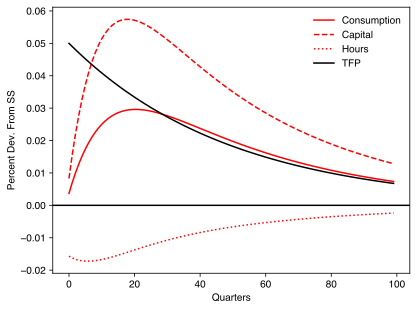

In [24]:
plt.plot(irfs_out1[0,0,:] / x_ss1[0], color='red',  label='Consumption')
plt.plot(irfs_out1[1,0,:] / x_ss1[1], color='red', linestyle='dashed', label='Capital')
plt.plot(irfs_out1[2,0,:] / x_ss1[2], color='red', linestyle='dotted', label='Hours')
plt.plot(irfs_out1[5,0,:], color='black', label="TFP")
plt.axhline(y=0 , color='black')
plt.xlabel('Quarters')
plt.ylabel('Percent Dev. From SS')
plt.legend(frameon=False)

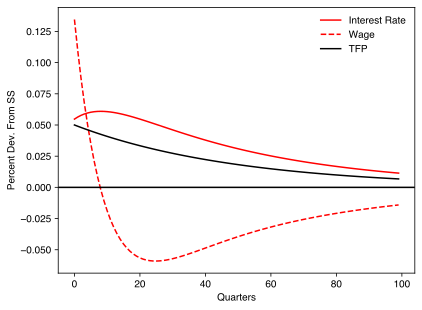

In [25]:
plt.plot(irfs_out1[3,0,:] / x_ss1[3], color='red',  label='Interest Rate')
plt.plot(irfs_out1[4,0,:] / x_ss1[4], color='red', linestyle='dashed', label='Wage')
plt.plot(irfs_out1[5,0,:], color='black', label="TFP")
plt.axhline(y=0 , color='black')
plt.xlabel('Quarters')
plt.ylabel('Percent Dev. From SS')
plt.legend(frameon=False)